Necessary imports

In [43]:
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score

if os.environ['COMPUTERNAME'] == 'FYNN':            # name of surface PC
    sys.path.append(r'C:\Users\Surface\Masterarbeit')
elif os.environ['COMPUTERNAME'] == 'FYNNS-PC':  # desktop name
    sys.path.append(r'C:\Users\test\Masterarbeit')
    
else:
    raise ValueError("Unbekannter Computername: " + os.environ['COMPUTERNAME'])


Create an ExactGP on a representative subset (2500 samples) of the data

(2600, 37) (2600,)


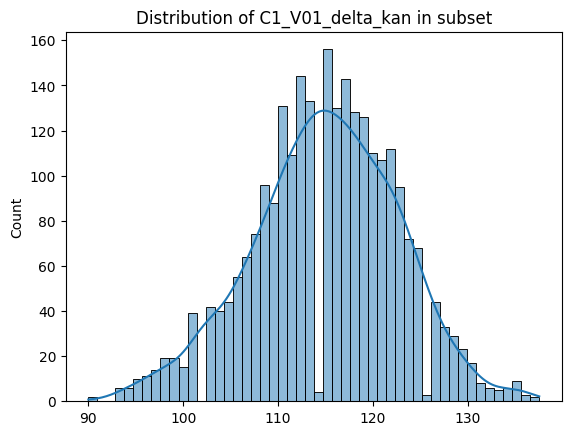

(1560, 37) (520, 37) (520, 37)
Feature names after preprocessing:
Index(['Ist_Blechhaltergewicht', 'Ist_Gegenhaltekraft_HL_1', 'T2', 'K1', 'T20',
       'K7', 'T23', 'K8', 'DS_10', 'GS_10', 'SD_10', 'LS_10', 'PP_10', 'TT_10',
       'TM5_10', 'RF_10', 'TD_10', 'is_weekend', 'dayofweek_sin',
       'dayofweek_cos', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos',
       'day_sin', 'day_cos', 'quarter_sin', 'quarter_cos', 'week_sin',
       'week_cos', 'Diff_Hubzahl', 'Diff_Ziehtiefe',
       'Diff_Ziehkissenverstellu', 'Diff_Stoesselverstellung-mm',
       'Diff_Gewichtsausgleich', 'BT_NR_freq', 'STP_NR_freq'],
      dtype='object')


In [72]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import data_prep

# check the computer name to determine the path to the data
if os.environ['COMPUTERNAME'] == 'FYNN':            # name of surface PC
    path = r"C:\Users\Surface\Masterarbeit\data\Produktionsdaten\WZ_2_Feature_Engineered_Fynn6.xlsx"
elif os.environ['COMPUTERNAME'] == 'FYNNS-PC':  # desktop name
    path = r"C:\Users\test\Masterarbeit\data\WZ_2_Feature_Engineered_Fynn6.xlsx"
    
df = pd.read_excel(path)

target = 'C1_V01_delta_kan'

x_data = df.drop(columns=[target])
y_data = df[target].to_numpy()

subset_x, x_rest, y_subset, y_rest = train_test_split(
    x_data, y_data, test_size=0.95, random_state=42)

print(subset_x.shape, y_subset.shape)

sns.histplot(y_subset, bins=50, kde =True)
plt.title('Distribution of C1_V01_delta_kan in subset')
plt.show()

X_temp, X_test, y_temp, y_test = train_test_split(subset_x, y_subset, test_size= 0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size= 0.25, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)

# use custom function "cat_transform" to map the categorical features with their frequencies
X_train_prep, X_val_prep, X_test_prep = data_prep.cat_transform(X_train, X_val, X_test, ['BT_NR', 'STP_NR'])
# print(X_train_prep.columns)

    # pipeline for preprocessing the data
# Standard Scaler for distribution with 0 mean and 1 std., normal distributed data
data_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
    ])

# get the feature names after preprocessing for the feature importance
feature_names = X_train.columns

print("Feature names after preprocessing:")
print(feature_names)

# fit the pipeline to the data and transform it
X_train = data_pipeline.fit_transform(X_train)
X_val = data_pipeline.transform(X_val)
X_test = data_pipeline.transform(X_test)

In [73]:
X_train_tensor = torch.from_numpy(X_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
X_test_tensor = torch.from_numpy(X_test).float() 
y_train_tensor = torch.from_numpy(y_train).float()
y_val_tensor = torch.from_numpy(y_val).float()
y_test_tensor = torch.from_numpy(y_test).float()
print(X_train_tensor.shape, X_val_tensor.shape, X_test_tensor.shape)
print(feature_names)

if torch.cuda.is_available():
    X_train_tensor = X_train_tensor.cuda()
    X_val_tensor = X_val_tensor.cuda()
    X_test_tensor = X_test_tensor.cuda()
    y_train_tensor = y_train_tensor.cuda()
    y_val_tensor = y_val_tensor.cuda()
    y_test_tensor = y_test_tensor.cuda()
    
print(type(X_train_tensor), X_train_tensor.shape)

torch.Size([1560, 37]) torch.Size([520, 37]) torch.Size([520, 37])
Index(['Ist_Blechhaltergewicht', 'Ist_Gegenhaltekraft_HL_1', 'T2', 'K1', 'T20',
       'K7', 'T23', 'K8', 'DS_10', 'GS_10', 'SD_10', 'LS_10', 'PP_10', 'TT_10',
       'TM5_10', 'RF_10', 'TD_10', 'is_weekend', 'dayofweek_sin',
       'dayofweek_cos', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos',
       'day_sin', 'day_cos', 'quarter_sin', 'quarter_cos', 'week_sin',
       'week_cos', 'Diff_Hubzahl', 'Diff_Ziehtiefe',
       'Diff_Ziehkissenverstellu', 'Diff_Stoesselverstellung-mm',
       'Diff_Gewichtsausgleich', 'BT_NR_freq', 'STP_NR_freq'],
      dtype='object')
<class 'torch.Tensor'> torch.Size([1560, 37])


In [85]:
import gpytorch

# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, X_train, y_train, likelihood):
        super(ExactGPModel, self).__init__(X_train, y_train, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=X_train.shape[1]))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train_tensor, y_train_tensor, likelihood)

y_mean = y_train_tensor.mean().item()
model.mean_module.initialize(constant=y_mean)  # Initialize the mean to the mean of the training targets

y_var = y_train_tensor.var().item()
model.covar_module.outputscale = y_var  # Initialize the outputscale to the variance of the training targets

training_iter = 200

# Find optimal model hyperparameters
if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)  



# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

best_val_r2 = -np.inf
patience = 10
counter = 0

for i in range(training_iter):
    model.train()
    likelihood.train()
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_train_tensor)
    
    # Calc loss and backprop gradients
    
    loss = -mll(output, y_train_tensor)
    loss.backward()
    # print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
    #     i + 1, training_iter, loss.item(),
    #     model.covar_module.base_kernel.lengthscale,
    #     model.likelihood.noise.item()
    # ))
    
    
    print(f'Iter {i + 1}/{training_iter} - Loss: {loss.item():.3f}')
    optimizer.step()
    
        # Evaluate model and likelihood
    model.eval()
    likelihood.eval()
    
    with torch.no_grad():
        f_val_preds = model(X_val_tensor)
        val_preds = likelihood(f_val_preds)
        
        val_mean = val_preds.mean.numpy()
        val_std = val_preds.stddev.numpy()
        val_nll = -val_preds.log_prob(y_val_tensor).mean().item()
        #print(val_nll)
        r2_score_val = r2_score(y_val, val_mean)
        
        print(f'Validation NLL: {val_nll} R²: {r2_score_val:.3f}')

        if r2_score_val > best_val_r2:
            best_val_r2 = r2_score_val
            best_model_state = model.state_dict()
            best_likelihood_state = likelihood.state_dict()
            counter = 0
        else:
            counter += 1
        
        if counter >= patience:
            print(f'Early stopping at iteration {i + 1} with best validation R²: {best_val_r2:.3f}')
            model.load_state_dict(best_model_state)
            likelihood.load_state_dict(best_likelihood_state)
            break
        
        

Iter 1/200 - Loss: 3.220
Validation NLL: 1583.028564453125 R²: 0.467
Iter 2/200 - Loss: 3.202
Validation NLL: 1574.3897705078125 R²: 0.486
Iter 3/200 - Loss: 3.172
Validation NLL: 1566.652587890625 R²: 0.503
Iter 4/200 - Loss: 3.176
Validation NLL: 1561.2274169921875 R²: 0.519
Iter 5/200 - Loss: 3.161
Validation NLL: 1556.715576171875 R²: 0.534
Iter 6/200 - Loss: 3.154
Validation NLL: 1555.768310546875 R²: 0.548
Iter 7/200 - Loss: 3.134
Validation NLL: 1552.4737548828125 R²: 0.561
Iter 8/200 - Loss: 3.114
Validation NLL: 1547.7181396484375 R²: 0.572
Iter 9/200 - Loss: 3.107
Validation NLL: 1549.3734130859375 R²: 0.582
Iter 10/200 - Loss: 3.111
Validation NLL: 1546.388427734375 R²: 0.592
Iter 11/200 - Loss: 3.083
Validation NLL: 1541.783203125 R²: 0.601
Iter 12/200 - Loss: 3.080
Validation NLL: 1541.6473388671875 R²: 0.607
Iter 13/200 - Loss: 3.055
Validation NLL: 1554.6109619140625 R²: 0.614
Iter 14/200 - Loss: 3.061
Validation NLL: 1552.8487548828125 R²: 0.620
Iter 15/200 - Loss: 3.05

In [88]:
# print the final model parameters and lengthscale and noise
print("Final model parameters:")
print(f"Mean: {model.mean_module.constant.item()}")
print(f"Outputscale: {model.covar_module.outputscale.item()}")
print(f"Lengthscale: {model.covar_module.base_kernel.lengthscale}")
print(f"Noise: {likelihood.noise.item()}")

Final model parameters:
Mean: 113.61990356445312
Outputscale: 51.10287857055664
Lengthscale: tensor([[0.6931, 4.8004, 2.4778, 1.1824, 1.7580, 1.5902, 1.1037, 1.2980, 2.9437,
         2.7419, 4.9328, 2.8789, 1.5130, 1.6880, 1.9913, 1.7527, 0.8714, 0.5967,
         1.7600, 4.8066, 4.0918, 3.3357, 0.7012, 2.8009, 6.9083, 6.9655, 5.4745,
         6.3091, 0.4460, 2.1571, 4.0213, 6.5790, 7.6934, 6.5663, 4.6311, 4.8091,
         0.5793]], grad_fn=<SoftplusBackward0>)
Noise: 5.240160942077637


c:\Users\Surface\Masterarbeit\.venv\Lib\site-packages\gpytorch\models\exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


R² on Train Data: 0.952
R² on Validation Data: 0.776
R² on Test Data: 0.806
Number of true values within the confidence interval: 495 out of 520
Coverage: 95.19%


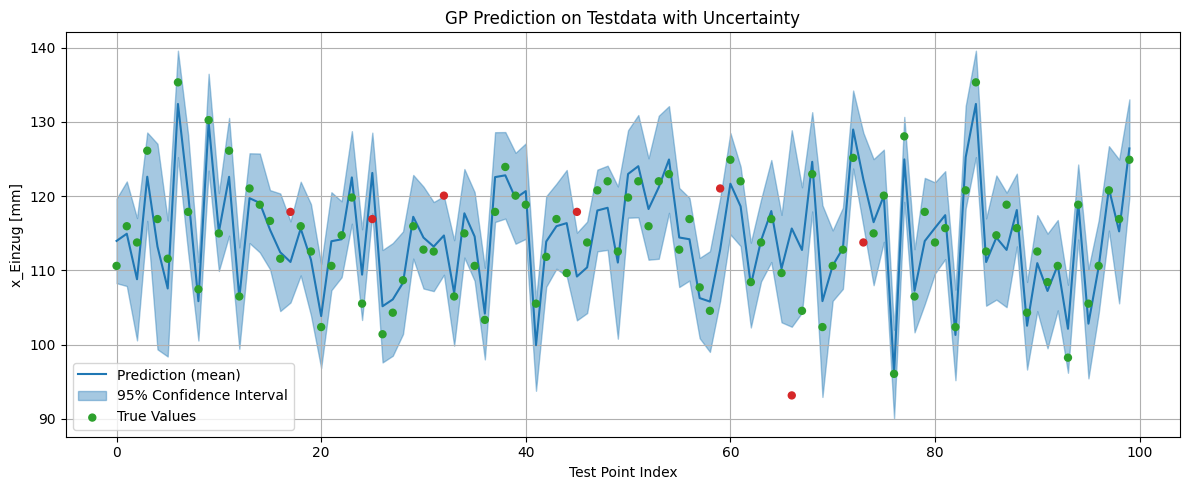

In [87]:
# Switch model and likelihood to evaluation mode
model.eval()
likelihood.eval()

# Predictive distribution for train data (no gradients required)
with torch.no_grad():
    f_preds = model(X_train_tensor)            # Latent function predictions
    y_preds = likelihood(f_preds)        # Observed predictions with noise

# Extract mean and standard deviation from predictions
train_mean = y_preds.mean.numpy()

# Calculate R² for the train data
r2_test = r2_score(y_train, train_mean)
print(f"R² on Train Data: {r2_test:.3f}")

with torch.no_grad():
    f_preds_val = model(X_val_tensor)            # Latent function predictions
    y_preds_val = likelihood(f_preds_val)        # Observed predictions with noise
    
val_eman = y_preds_val.mean.numpy()

r2_val = r2_score(y_val, val_eman)
print(f"R² on Validation Data: {r2_val:.3f}")

# Predictive distribution for test data (no gradients required)
with torch.no_grad():
    f_preds = model(X_test_tensor)            # Latent function predictions
    y_preds = likelihood(f_preds)        # Observed predictions with noise

# Extract mean and standard deviation from predictions
test_mean = y_preds.mean.numpy()
test_stddev = y_preds.stddev.numpy()

# Calculate R² for the test data
r2_test = r2_score(y_test, test_mean)
print(f"R² on Test Data: {r2_test:.3f}")

num_points = 100
np.random.seed(42)

random_indices = np.random.choice(len(X_test), num_points, replace=False)
random_indices.sort()

# Define the confidence interval bounds (95% CI ≈ mean ± 2*std)
gp_lower = test_mean - 2*test_stddev
gp_upper = test_mean + 2*test_stddev

# Check whether each true value lies within the 95% confidence interval
# If yes, the point will be green; if not, red
in_interval = (y_test >= gp_lower) & (y_test <= gp_upper)

counter = 0
# Print whether each true value is within the confidence interval
for i in in_interval:
    if i:
        counter += 1

print(f"Number of true values within the confidence interval: {counter} out of {len(in_interval)}")

# Calculate coverage (percentage of true values within the CI)
coverage = np.mean(in_interval) * 100  # in percentage

# Print the coverage value
print(f"Coverage: {coverage:.2f}%")

# Check whether each true value from random indices lies within the 95% confidence interval
# If yes, the point will be green; if not, red
in_interval_rand_indi = (y_test[random_indices] >= gp_lower[random_indices]) & (y_test[random_indices] <= gp_upper[random_indices])
colors = ['tab:green' if inside else 'tab:red' for inside in in_interval_rand_indi]

# Plotting the prediction with uncertainty and true values
plt.figure(figsize=(12, 5))
x_axis = np.arange(num_points)

# Plot predicted mean
plt.plot(x_axis, test_mean[random_indices], label="Prediction (mean)", color='tab:blue')

# Shade the 95% confidence interval (±2 standard deviations)
plt.fill_between(x_axis, gp_lower[random_indices], gp_upper[random_indices],
                 alpha=0.4, color='tab:blue', label='95% Confidence Interval')

# Plot true target values as orange dots
plt.scatter(x_axis, y_test[random_indices], label="True Values", c=colors, s=25, zorder=3)

# Add plot labels and formatting
plt.title("GP Prediction on Testdata with Uncertainty")
plt.xlabel("Test Point Index")
plt.ylabel("x_Einzug [mm]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [91]:
# Speichern
torch.save({
    'model_state_dict': model.state_dict(),
    'likelihood_state_dict': likelihood.state_dict()
}, "exact_gp.pth")

In [ ]:
checkpoint = torch.load("exact_gp.pth")

model = ExactGPModel(X_train_tensor, y_train_tensor, gpytorch.likelihoods.GaussianLikelihood())
likelihood = gpytorch.likelihoods.GaussianLikelihood()

model.load_state_dict(checkpoint['model_state_dict'])
likelihood.load_state_dict(checkpoint['likelihood_state_dict'])

In [90]:
lengthscale = model.covar_module.base_kernel.lengthscale.detach().cpu()
outputscale = model.covar_module.outputscale.detach().cpu()
noise = likelihood.noise.detach().cpu()

print(f"Lengthscale: {lengthscale}")
print(f"Outputscale: {outputscale}")
print(f"Noise: {noise}")

Lengthscale: tensor([[0.6931, 4.8004, 2.4778, 1.1824, 1.7580, 1.5902, 1.1037, 1.2980, 2.9437,
         2.7419, 4.9328, 2.8789, 1.5130, 1.6880, 1.9913, 1.7527, 0.8714, 0.5967,
         1.7600, 4.8066, 4.0918, 3.3357, 0.7012, 2.8009, 6.9083, 6.9655, 5.4745,
         6.3091, 0.4460, 2.1571, 4.0213, 6.5790, 7.6934, 6.5663, 4.6311, 4.8091,
         0.5793]])
Outputscale: 51.10287857055664
Noise: tensor([5.2402])


Transformation Pipeline

In [ ]:
import data_prep

X_train, X_val, X_test, y_train, y_val, y_test, feature_names = data_prep.load_tranform_and_split_data('C1_V01_delta_kan', split_ratio=(0.6, 0.2, 0.2))

# convert the data to PyTorch tensors
# and add an extra dimension for the target variable
X_train_tensor = torch.from_numpy(X_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
X_test_tensor = torch.from_numpy(X_test).float() 
y_train_tensor = torch.from_numpy(y_train).float() # Add extra dimension for compatibility
y_val_tensor = torch.from_numpy(y_val).float()
y_test_tensor = torch.from_numpy(y_test).float()
print(X_train_tensor.shape, X_val_tensor.shape, X_test_tensor.shape)
print(feature_names)

if torch.cuda.is_available():
    X_train_tensor = X_train_tensor.cuda()
    X_val_tensor = X_val_tensor.cuda()
    X_test_tensor = X_test_tensor.cuda()
    y_train_tensor = y_train_tensor.cuda()
    y_val_tensor = y_val_tensor.cuda()
    y_test_tensor = y_test_tensor.cuda()

torch.Size([31206, 37]) torch.Size([10402, 37]) torch.Size([10403, 37])
Index(['Ist_Blechhaltergewicht', 'Ist_Gegenhaltekraft_HL_1', 'T2', 'K1', 'T20',
       'K7', 'T23', 'K8', 'DS_10', 'GS_10', 'SD_10', 'LS_10', 'PP_10', 'TT_10',
       'TM5_10', 'RF_10', 'TD_10', 'is_weekend', 'dayofweek_sin',
       'dayofweek_cos', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos',
       'day_sin', 'day_cos', 'quarter_sin', 'quarter_cos', 'week_sin',
       'week_cos', 'Diff_Hubzahl', 'Diff_Ziehtiefe',
       'Diff_Ziehkissenverstellu', 'Diff_Stoesselverstellung-mm',
       'Diff_Gewichtsausgleich', 'BT_NR_freq', 'STP_NR_freq'],
      dtype='object')


Stochastic Variational GP Regression Implementation

Natural Gradient Descent with Variational Models for better and faster convergence

In [ ]:
import gpytorch
from gpytorch.models import ApproximateGP


#create a TensorDataset and DataLoader for the training data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

class GPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.NaturalVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module  = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=X_train.shape[1]))
        
        
        self.mean_module.initialize(constant=y_train_tensor.mean().item())  # Initialize the mean to the mean of the training targets
        self.covar_module.base_kernel.lengthscale = lengthscale
        self.covar_module.outputscale = outputscale  # Initialize the outputscale to the variance of the training targets
        
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
    
# Define the inducing points
# Randomly select 500 inducing points from the training data
num_inducing_points = 1500
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=num_inducing_points, random_state=42).fit(X_train)
inducing_points = torch.from_numpy(kmeans.cluster_centers_).float()

print(inducing_points.shape)
print(inducing_points)

model = GPModel(inducing_points = inducing_points)
likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = noise

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

torch.Size([1500, 37])
tensor([[-0.0354,  0.8450,  0.6694,  ...,  0.7666,  0.1377,  1.0920],
        [-0.0354,  0.8913,  0.0337,  ..., -0.6977, -0.0546,  1.0759],
        [-0.0354,  0.8450, -1.1064,  ..., -0.6977, -1.2125, -0.0840],
        ...,
        [-0.0354, -0.7937,  0.4565,  ...,  2.2310, -0.1493, -1.4999],
        [-0.0354,  0.8450, -0.2772,  ...,  0.7666, -0.6365,  1.0335],
        [-0.0354, -0.5916,  0.4762,  ...,  0.7666, -0.0317,  1.0335]])


In [ ]:
num_epochs = 100

model.train()
likelihood.train()

variational_ngd_optimizer = gpytorch.optim.NGD(model.variational_parameters(), num_data= y_train_tensor.size(0), lr=0.1)

hyperparameter_optimizer = torch.optim.Adam([
    {'params': model.hyperparameters()},
    {'params': likelihood.parameters()},
], lr=0.02)

# VariationalELBO is used for training
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=len(train_loader.dataset))


for epoch in range(num_epochs):
    epoch_loss = 0.0
    model.train()
    likelihood.train()
    for x_batch, y_batch in train_loader:
        # Zero gradients from previous iteration        
        variational_ngd_optimizer.zero_grad()
        hyperparameter_optimizer.zero_grad()
        output = model(x_batch)
        loss = -mll(output, y_batch)
        # Print the loss for every tenth batch
        loss.backward()
        variational_ngd_optimizer.step()
        hyperparameter_optimizer.step()

        epoch_loss += loss.item()
        
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(train_loader):.4f}')         # Print the average loss for the epoch
          
    model.eval()
    likelihood.eval()
    
    with torch.no_grad():
        f_val_preds = model(X_val_tensor)
        val_preds = likelihood(f_val_preds)
        
        val_mean = val_preds.mean.numpy()
        val_std = val_preds.stddev.numpy()
        val_nll = -val_preds.log_prob(y_val_tensor).mean().item()
        #print(val_nll)
        r2_score_val = r2_score(y_val, val_mean)
        
        print(f'Validation NLL: {val_nll} R²: {r2_score_val:.3f}')

        if r2_score_val > best_val_r2:
            best_val_r2 = r2_score_val
            best_model_state = model.state_dict()
            best_likelihood_state = likelihood.state_dict()
            counter = 0
        else:
            counter += 1
        
        if counter >= patience:
            print(f'Early stopping at iteration {i + 1} with best validation R²: {best_val_r2:.3f}')
            model.load_state_dict(best_model_state)
            likelihood.load_state_dict(best_likelihood_state)
            break

Epoch 1/75, R^2: -11.8903
Epoch 1/75, Loss: 26002.5260
Noise: 0.7002415657043457
Epoch 2/75, R^2: -10.6119
Epoch 2/75, Loss: 690.2896
Noise: 0.7006682753562927
Epoch 3/75, R^2: -9.0376
Epoch 3/75, Loss: 629.3093
Noise: 0.7008280158042908
Epoch 4/75, R^2: -8.2024
Epoch 4/75, Loss: 579.7142
Noise: 0.700982928276062
Epoch 5/75, R^2: -7.2311
Epoch 5/75, Loss: 533.6653
Noise: 0.7011401653289795
Epoch 6/75, R^2: -6.6487
Epoch 6/75, Loss: 495.7109
Noise: 0.7012982964515686
Epoch 7/75, R^2: -6.1046
Epoch 7/75, Loss: 465.5840
Noise: 0.7014568448066711
Epoch 8/75, R^2: -5.3521
Epoch 8/75, Loss: 431.9090
Noise: 0.7016152739524841
Epoch 9/75, R^2: -5.0600
Epoch 9/75, Loss: 404.3476
Noise: 0.701766312122345
Epoch 10/75, R^2: -4.5589
Epoch 10/75, Loss: 381.6322
Noise: 0.7019193172454834
Epoch 11/75, R^2: -4.0827
Epoch 11/75, Loss: 358.9742
Noise: 0.7020674347877502
Epoch 12/75, R^2: -3.6647
Epoch 12/75, Loss: 339.4922
Noise: 0.7022128701210022
Epoch 13/75, R^2: -3.5329
Epoch 13/75, Loss: 322.0863
No

KeyboardInterrupt: 

Make Predictions

In [76]:
model.eval()
likelihood.eval()
means = []
variances = []
stddevs = []
with torch.no_grad():
    # Make predictions on the test set

    preds = likelihood(model(X_test_tensor))
    
    # Mean:
    means.append(preds.mean.cpu())
    
    # Variance
    variances.append(preds.variance.cpu())
    
    # Standard Deviation
    stddevs.append(preds.stddev.cpu())

means = torch.cat(means)
variances = torch.cat(variances)
stddevs = torch.cat(stddevs)  

# check type of means, variances, stddevs
print(type(means), type(variances), type(stddevs))
print("Means shape:", means.shape)
print("Variances shape:", variances.shape)
print("Standard Deviations shape:", stddevs.shape)


<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Means shape: torch.Size([10403])
Variances shape: torch.Size([10403])
Standard Deviations shape: torch.Size([10403])


R² on Test Data: -0.159
Number of true values within the confidence interval: 3493 out of 10403
Coverage: 33.58%


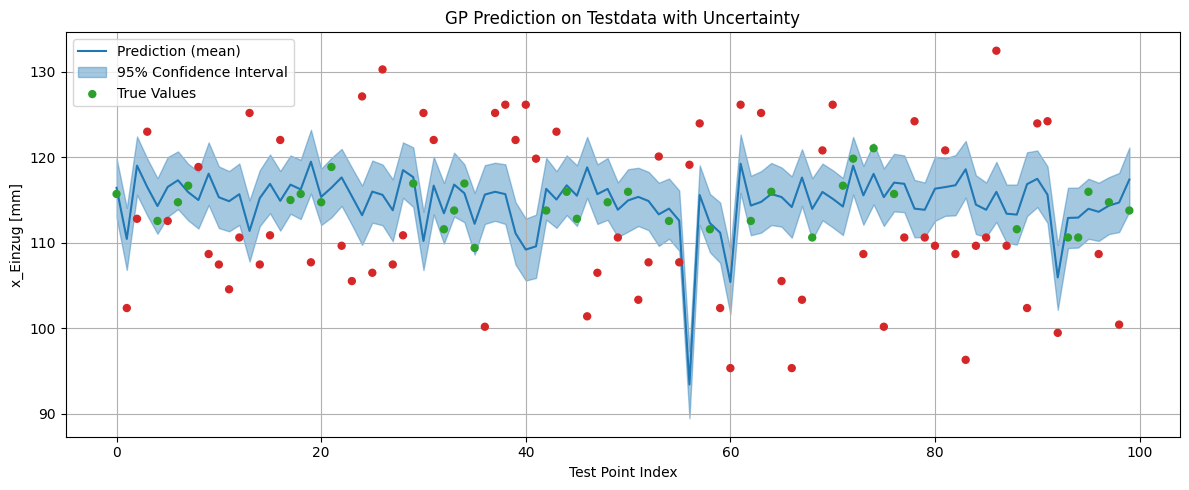

In [77]:
num_points = 100
np.random.seed(42)

random_indices = np.random.choice(len(X_test), num_points, replace=False)
random_indices.sort()

means = means.numpy()
stddevs = stddevs.numpy()
# Calculate R² for the test data
r2_test = r2_score(y_test, means)
print(f"R² on Test Data: {r2_test:.3f}")

# Define the confidence interval bounds (95% CI ≈ mean ± 2*std)
gp_lower = means - 2*stddevs
gp_upper = means + 2*stddevs

# Check whether each true value lies within the 95% confidence interval
# If yes, the point will be green; if not, red
in_interval = (y_test >= gp_lower) & (y_test <= gp_upper)

counter = 0
# Print whether each true value is within the confidence interval
for i in in_interval:
    if i:
        counter += 1

print(f"Number of true values within the confidence interval: {counter} out of {len(in_interval)}")

# Calculate coverage (percentage of true values within the CI)
coverage = np.mean(in_interval) * 100  # in percentage

# Print the coverage value
print(f"Coverage: {coverage:.2f}%")

# Check whether each true value from random indices lies within the 95% confidence interval
# If yes, the point will be green; if not, red
in_interval_rand_indi = (y_test[random_indices] >= gp_lower[random_indices]) & (y_test[random_indices] <= gp_upper[random_indices])
colors = ['tab:green' if inside else 'tab:red' for inside in in_interval_rand_indi]

# Plotting the prediction with uncertainty and true values
plt.figure(figsize=(12, 5))
x_axis = np.arange(num_points)

# Plot predicted mean
plt.plot(x_axis, means[random_indices], label="Prediction (mean)", color='tab:blue')

# Shade the 95% confidence interval (±2 standard deviations)
plt.fill_between(x_axis, gp_lower[random_indices], gp_upper[random_indices],
                 alpha=0.4, color='tab:blue', label='95% Confidence Interval')

# Plot true target values as orange dots
plt.scatter(x_axis, y_test[random_indices], label="True Values", c=colors, s=25, zorder=3)

# Add plot labels and formatting
plt.title("GP Prediction on Testdata with Uncertainty")
plt.xlabel("Test Point Index")
plt.ylabel("x_Einzug [mm]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Exact GP Model Definition and Training

In [6]:
import gpytorch


# Define an Exact GP Model using a constant mean and an RBF (Radial Basis Function) kernel
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, X_train, y_train, likelihood):
        super(ExactGPModel, self).__init__(X_train, y_train, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()  # Constant mean function
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel())  # RBF kernel scaled by a learnable factor

    def forward(self, X):
        mean_x = self.mean_module(X)           # Compute the mean of the GP
        covar_x = self.covar_module(X)         # Compute the covariance (kernel)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Define the Gaussian likelihood
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# Initialize the GP model with training data and likelihood
model = ExactGPModel(X_train_tensor, y_train_tensor, likelihood)

# Set model and likelihood into training mode
model.train()
likelihood.train()

# if torch.cuda.is_available():
#     model = model.cuda()
#     likelihood = likelihood.cuda()
# Use Adam optimizer to train kernel and likelihood parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# Marginal log likelihood is used as the loss function for GP training
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Number of training iterations
training_iter = 1

# Training loop
for i in range(training_iter):
    optimizer.zero_grad()              # Reset gradients
    output = model(X_train_tensor)               # Forward pass
    loss = -mll(output, y_train_tensor)          # Negative marginal log likelihood (to minimize)
    loss.backward()                    # Backpropagation

    # Print progress every 10 iterations
    if i % 1 == 0:
        print(f' Iter {i+1:d}/{training_iter:d} - Loss: {loss.item(): .3f}',
              'squared lengthscale: ',
              f'{model.covar_module.base_kernel.lengthscale.item(): .3f}',
              f'noise variance: {model.likelihood.noise.item(): .3f}')

    optimizer.step()                   # Update parameters

RuntimeError: [enforce fail at alloc_cpu.cpp:114] data. DefaultCPUAllocator: not enough memory: you tried to allocate 3896505984 bytes.

Manual Grid Search for GP

Data Plotting

c:\Users\Surface\Masterarbeit\.venv\Lib\site-packages\gpytorch\models\exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


R² on Test Data: 1.000
R² on Test Data: 1.000
Coverage: 100.00%


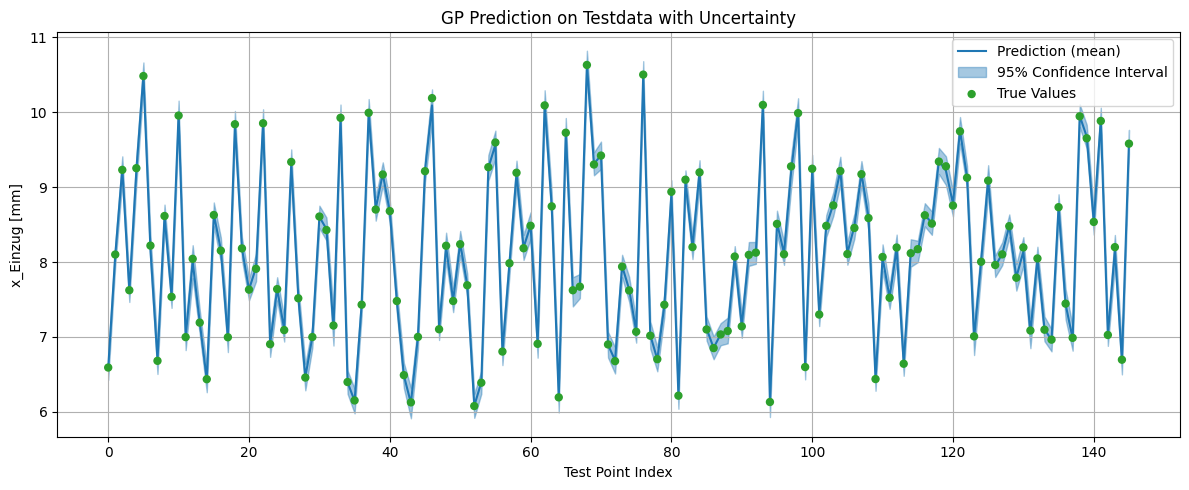

In [ ]:
# Switch model and likelihood to evaluation mode
model.eval()
likelihood.eval()

# Predictive distribution for train data (no gradients required)
with torch.no_grad():
    f_preds = model(X_train)            # Latent function predictions
    y_preds = likelihood(f_preds)        # Observed predictions with noise

# Extract mean and standard deviation from predictions
train_mean = y_preds.mean.numpy()

# Calculate R² for the train data
r2_test = r2_score(y_train.numpy(), train_mean)
print(f"R² on Test Data: {r2_test:.3f}")

# Predictive distribution for test data (no gradients required)
with torch.no_grad():
    f_preds = model(X_test)            # Latent function predictions
    y_preds = likelihood(f_preds)        # Observed predictions with noise

# Extract mean and standard deviation from predictions
test_mean = y_preds.mean.numpy()
test_stddev = y_preds.stddev.numpy()

# Calculate R² for the test data
r2_test = r2_score(y_test.numpy(), test_mean)
print(f"R² on Test Data: {r2_test:.3f}")

# Define the confidence interval bounds (95% CI ≈ mean ± 2*std)
gp_lower = test_mean - 2*test_stddev
gp_upper = test_mean + 2*test_stddev

# Check whether each true value lies within the 95% confidence interval
# If yes, the point will be green; if not, red
in_interval = (y_test.numpy() >= gp_lower) & (y_test.numpy() <= gp_upper)
colors = ['tab:green' if inside else 'tab:red' for inside in in_interval]

# Calculate coverage (percentage of true values within the CI)
coverage = np.mean(in_interval) * 100  # in percentage

# Print the coverage value
print(f"Coverage: {coverage:.2f}%")

# Plotting the prediction with uncertainty and true values
plt.figure(figsize=(12, 5))
x_axis = np.arange(len(X_test))

# Plot predicted mean
plt.plot(x_axis, test_mean, label="Prediction (mean)", color='tab:blue')

# Shade the 95% confidence interval (±2 standard deviations)
plt.fill_between(x_axis, gp_lower, gp_upper,
                 alpha=0.4, color='tab:blue', label='95% Confidence Interval')

# Plot true target values as orange dots
plt.scatter(x_axis, y_test.numpy(), label="True Values", c=colors, s=25, zorder=3)

# Add plot labels and formatting
plt.title("GP Prediction on Testdata with Uncertainty")
plt.xlabel("Test Point Index")
plt.ylabel("x_Einzug [mm]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Training mit Cross Validation

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle = True, random_state= 42)

X = torch.from_numpy(data_prep).float()
y = torch.from_numpy(data_labels).float()

# Number of training iterations
training_iter = 100

for train_idx, test_idx in kf.split(data_prep):
  X_tr, X_te = X[train_idx], X[test_idx]
  y_tr, y_te = y[train_idx], y[test_idx]

  # Define the Gaussian likelihood
  likelihood = gpytorch.likelihoods.GaussianLikelihood()

  # Initialize the GP model with training data and likelihood
  model = ExactGPModel(X_tr, y_tr, likelihood)

  # Set model and likelihood into training mode
  model.train()
  likelihood.train()

  # Use Adam optimizer to train kernel and likelihood parameters
  optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

  # Marginal log likelihood is used as the loss function for GP training
  mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

  # Training loop
  for i in range(training_iter):
      optimizer.zero_grad()              # Reset gradients
      output = model(X_tr)               # Forward pass
      loss = -mll(output, y_tr)          # Negative marginal log likelihood (to minimize)
      loss.backward()                    # Backpropagation

      # Print progress every 10 iterations
      if i % 10 == 0:
          print(f' Iter {i+1:d}/{training_iter:d} - Loss: {loss.item(): .3f}',
                'squared lengthscale: ',
                f'{model.covar_module.base_kernel.lengthscale.item(): .3f}',
                f'noise variance: {model.likelihood.noise.item(): .3f}')

      optimizer.step()                   # Update parameters

  # Switch model and likelihood to evaluation mode
  model.eval()
  likelihood.eval()

  # Predictive distribution for train data (no gradients required)
  with torch.no_grad():
      f_preds = model(X_tr)            # Latent function predictions
      y_preds = likelihood(f_preds)        # Observed predictions with noise

  # Extract mean and standard deviation from predictions
  train_mean = y_preds.mean.numpy()
 
  # Calculate R² for the train data
  r2_test = r2_score(y_tr.numpy(), train_mean)
  print(f"R² on Train Data: {r2_test:.3f}")

  # Predictive distribution for test data (no gradients required)
  with torch.no_grad():
      f_preds = model(X_te)            # Latent function predictions
      y_preds = likelihood(f_preds)        # Observed predictions with noise

  # Extract mean and standard deviation from predictions
  test_mean = y_preds.mean.numpy()
 
  # Calculate R² for the test data
  r2_test = r2_score(y_te.numpy(), test_mean)
  print(f"R² on Test Data: {r2_test:.3f}")

 Iter 1/100 - Loss:  11.669 squared lengthscale:   0.693 noise variance:  0.693
 Iter 11/100 - Loss:  2.197 squared lengthscale:   1.197 noise variance:  1.066
 Iter 21/100 - Loss:  1.540 squared lengthscale:   1.526 noise variance:  1.052
 Iter 31/100 - Loss:  1.287 squared lengthscale:   1.715 noise variance:  0.823
 Iter 41/100 - Loss:  1.050 squared lengthscale:   1.832 noise variance:  0.530
 Iter 51/100 - Loss:  0.771 squared lengthscale:   1.919 noise variance:  0.284
 Iter 61/100 - Loss:  0.453 squared lengthscale:   2.001 noise variance:  0.130
 Iter 71/100 - Loss:  0.115 squared lengthscale:   2.091 noise variance:  0.054
 Iter 81/100 - Loss: -0.224 squared lengthscale:   2.195 noise variance:  0.022
 Iter 91/100 - Loss: -0.559 squared lengthscale:   2.318 noise variance:  0.009
R² on Train Data: 1.000


c:\Users\Surface\Masterarbeit\.venv\Lib\site-packages\gpytorch\models\exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


R² on Test Data: 1.000
 Iter 1/100 - Loss:  11.626 squared lengthscale:   0.693 noise variance:  0.693
 Iter 11/100 - Loss:  2.197 squared lengthscale:   1.197 noise variance:  1.066
 Iter 21/100 - Loss:  1.539 squared lengthscale:   1.527 noise variance:  1.052
 Iter 31/100 - Loss:  1.286 squared lengthscale:   1.716 noise variance:  0.821
 Iter 41/100 - Loss:  1.048 squared lengthscale:   1.834 noise variance:  0.529
 Iter 51/100 - Loss:  0.768 squared lengthscale:   1.922 noise variance:  0.282
 Iter 61/100 - Loss:  0.449 squared lengthscale:   2.004 noise variance:  0.129
 Iter 71/100 - Loss:  0.111 squared lengthscale:   2.094 noise variance:  0.054
 Iter 81/100 - Loss: -0.230 squared lengthscale:   2.199 noise variance:  0.022
 Iter 91/100 - Loss: -0.565 squared lengthscale:   2.322 noise variance:  0.009
R² on Train Data: 1.000
R² on Test Data: 1.000


c:\Users\Surface\Masterarbeit\.venv\Lib\site-packages\gpytorch\models\exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


 Iter 1/100 - Loss:  11.619 squared lengthscale:   0.693 noise variance:  0.693
 Iter 11/100 - Loss:  2.194 squared lengthscale:   1.197 noise variance:  1.065
 Iter 21/100 - Loss:  1.537 squared lengthscale:   1.527 noise variance:  1.049
 Iter 31/100 - Loss:  1.283 squared lengthscale:   1.716 noise variance:  0.817
 Iter 41/100 - Loss:  1.043 squared lengthscale:   1.833 noise variance:  0.524
 Iter 51/100 - Loss:  0.762 squared lengthscale:   1.921 noise variance:  0.279
 Iter 61/100 - Loss:  0.442 squared lengthscale:   2.003 noise variance:  0.127
 Iter 71/100 - Loss:  0.102 squared lengthscale:   2.093 noise variance:  0.053
 Iter 81/100 - Loss: -0.238 squared lengthscale:   2.198 noise variance:  0.022
 Iter 91/100 - Loss: -0.573 squared lengthscale:   2.322 noise variance:  0.009


c:\Users\Surface\Masterarbeit\.venv\Lib\site-packages\gpytorch\models\exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


R² on Train Data: 1.000
R² on Test Data: 1.000
 Iter 1/100 - Loss:  11.697 squared lengthscale:   0.693 noise variance:  0.693
 Iter 11/100 - Loss:  2.194 squared lengthscale:   1.197 noise variance:  1.063
 Iter 21/100 - Loss:  1.536 squared lengthscale:   1.527 noise variance:  1.046
 Iter 31/100 - Loss:  1.282 squared lengthscale:   1.715 noise variance:  0.814
 Iter 41/100 - Loss:  1.042 squared lengthscale:   1.832 noise variance:  0.521
 Iter 51/100 - Loss:  0.761 squared lengthscale:   1.919 noise variance:  0.277
 Iter 61/100 - Loss:  0.440 squared lengthscale:   2.001 noise variance:  0.126
 Iter 71/100 - Loss:  0.102 squared lengthscale:   2.090 noise variance:  0.053
 Iter 81/100 - Loss: -0.236 squared lengthscale:   2.195 noise variance:  0.021
 Iter 91/100 - Loss: -0.569 squared lengthscale:   2.319 noise variance:  0.009
R² on Train Data: 1.000
R² on Test Data: 1.000


c:\Users\Surface\Masterarbeit\.venv\Lib\site-packages\gpytorch\models\exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


 Iter 1/100 - Loss:  11.586 squared lengthscale:   0.693 noise variance:  0.693
 Iter 11/100 - Loss:  2.183 squared lengthscale:   1.196 noise variance:  1.063
 Iter 21/100 - Loss:  1.531 squared lengthscale:   1.525 noise variance:  1.044
 Iter 31/100 - Loss:  1.276 squared lengthscale:   1.713 noise variance:  0.808
 Iter 41/100 - Loss:  1.034 squared lengthscale:   1.829 noise variance:  0.514
 Iter 51/100 - Loss:  0.750 squared lengthscale:   1.917 noise variance:  0.271
 Iter 61/100 - Loss:  0.427 squared lengthscale:   1.999 noise variance:  0.122
 Iter 71/100 - Loss:  0.087 squared lengthscale:   2.089 noise variance:  0.051
 Iter 81/100 - Loss: -0.254 squared lengthscale:   2.195 noise variance:  0.021
 Iter 91/100 - Loss: -0.589 squared lengthscale:   2.319 noise variance:  0.009
R² on Train Data: 1.000
R² on Test Data: 0.999


c:\Users\Surface\Masterarbeit\.venv\Lib\site-packages\gpytorch\models\exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
